# CNN on CIFAR10 with different optimizers

In [1]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: kwang126 (csi5340). Use `wandb login --relogin` to force relogin


## Import libraries

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image

import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Load dataset

In [3]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 100)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [5]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst_train = []
    loss_lst_train = []
    accuracy_lst_val = []
    loss_lst_val = []
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        model.train()
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst_train.append((correct/num_labels).cpu().item())
        loss_lst_train.append(total_loss/counter)

        # Validation
        model.eval()
        total_loss_val = 0
        correct_val = 0
        num_labels_val = 0
        counter_val = 0
        model.eval()
        for batch_idx, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)

            output = model(X)

            loss = loss_func(output, y)
            total_loss_val += loss.item()

            predicted = torch.max(output,1)[1]
            correct_val += (predicted == y).sum()
            num_labels_val += len(y)
            counter_val += 1
        loss_lst_val.append(total_loss_val/counter_val)
        accuracy_lst_val.append((correct_val/num_labels_val).cpu().item())

        # Log
        wandb.log({'Training Accuracy': accuracy_lst_train[-1], 'Training Loss': loss_lst_train[-1], 'Testing Accuracy': accuracy_lst_val[-1], 'Testing Loss': loss_lst_val[-1]})

        print('Epoch %d, Training Loss %4f, Training Accuracy %4f, Testing Loss %4f, Testing Accuracy %4f'
            % (epoch+1, total_loss/counter, correct/num_labels, total_loss_val/counter_val, correct_val/num_labels_val))
    return accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val

## Training

In [6]:
lr = 0.001

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=100, bias=True)
)


In [7]:
num_epoch = 100

In [8]:
SGD_run = wandb.init(project="CSI 5340 Project", entity="kwang126", name='SGD')
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.95, weight_decay=5e-4)

accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)

SGD_run.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kwang126. Use `wandb login --relogin` to force relogin


Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Training Loss 1.712425, Training Accuracy 0.397740, Testing Loss 1.344705, Testing Accuracy 0.514700


Epoch 2/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 1.360116, Training Accuracy 0.515540, Testing Loss 1.582994, Testing Accuracy 0.469300


Epoch 3/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 1.238880, Training Accuracy 0.560120, Testing Loss 1.455026, Testing Accuracy 0.501700


Epoch 4/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 1.178157, Training Accuracy 0.582360, Testing Loss 1.239612, Testing Accuracy 0.564400


Epoch 5/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 1.125515, Training Accuracy 0.602520, Testing Loss 1.445251, Testing Accuracy 0.522300


Epoch 6/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 1.079753, Training Accuracy 0.623960, Testing Loss 1.223278, Testing Accuracy 0.594000


Epoch 7/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 1.062795, Training Accuracy 0.628180, Testing Loss 1.095291, Testing Accuracy 0.617100


Epoch 8/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 1.019575, Training Accuracy 0.644040, Testing Loss 1.196767, Testing Accuracy 0.587100


Epoch 9/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.999150, Training Accuracy 0.650600, Testing Loss 1.134663, Testing Accuracy 0.625500


Epoch 10/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.976220, Training Accuracy 0.661320, Testing Loss 1.488136, Testing Accuracy 0.520400


Epoch 11/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.960360, Training Accuracy 0.667380, Testing Loss 1.018021, Testing Accuracy 0.652900


Epoch 12/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.934301, Training Accuracy 0.676480, Testing Loss 0.910477, Testing Accuracy 0.688900


Epoch 13/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.916290, Training Accuracy 0.682400, Testing Loss 0.954275, Testing Accuracy 0.668900


Epoch 14/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.897863, Training Accuracy 0.688280, Testing Loss 1.068815, Testing Accuracy 0.640900


Epoch 15/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.886621, Training Accuracy 0.695700, Testing Loss 1.033942, Testing Accuracy 0.647100


Epoch 16/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.861031, Training Accuracy 0.702660, Testing Loss 0.954042, Testing Accuracy 0.684200


Epoch 17/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.861795, Training Accuracy 0.701760, Testing Loss 0.883699, Testing Accuracy 0.694900


Epoch 18/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.847063, Training Accuracy 0.707580, Testing Loss 0.993998, Testing Accuracy 0.664600


Epoch 19/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.839113, Training Accuracy 0.709800, Testing Loss 1.002769, Testing Accuracy 0.657700


Epoch 20/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.829366, Training Accuracy 0.713460, Testing Loss 0.863721, Testing Accuracy 0.703500


Epoch 21/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.812995, Training Accuracy 0.719640, Testing Loss 1.549875, Testing Accuracy 0.539700


Epoch 22/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.803928, Training Accuracy 0.722000, Testing Loss 1.007873, Testing Accuracy 0.657000


Epoch 23/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.800921, Training Accuracy 0.726340, Testing Loss 0.926689, Testing Accuracy 0.672100


Epoch 24/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.793215, Training Accuracy 0.725260, Testing Loss 0.793769, Testing Accuracy 0.728600


Epoch 25/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.790472, Training Accuracy 0.727000, Testing Loss 0.922942, Testing Accuracy 0.697000


Epoch 26/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.769888, Training Accuracy 0.736160, Testing Loss 0.823978, Testing Accuracy 0.718400


Epoch 27/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.761258, Training Accuracy 0.739180, Testing Loss 0.800695, Testing Accuracy 0.723700


Epoch 28/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.767516, Training Accuracy 0.736420, Testing Loss 0.818851, Testing Accuracy 0.710500


Epoch 29/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.758275, Training Accuracy 0.739240, Testing Loss 0.724059, Testing Accuracy 0.756200


Epoch 30/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.743493, Training Accuracy 0.744320, Testing Loss 0.844371, Testing Accuracy 0.718900


Epoch 31/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.742611, Training Accuracy 0.744460, Testing Loss 1.230201, Testing Accuracy 0.625300


Epoch 32/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.733775, Training Accuracy 0.748560, Testing Loss 0.803737, Testing Accuracy 0.726300


Epoch 33/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.728146, Training Accuracy 0.749580, Testing Loss 0.791448, Testing Accuracy 0.730500


Epoch 34/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.720649, Training Accuracy 0.752100, Testing Loss 0.821148, Testing Accuracy 0.727400


Epoch 35/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.718928, Training Accuracy 0.753520, Testing Loss 0.786362, Testing Accuracy 0.724700


Epoch 36/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.711700, Training Accuracy 0.755300, Testing Loss 0.788250, Testing Accuracy 0.730700


Epoch 37/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.707572, Training Accuracy 0.756240, Testing Loss 0.742908, Testing Accuracy 0.747400


Epoch 38/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.706066, Training Accuracy 0.756780, Testing Loss 0.995129, Testing Accuracy 0.681300


Epoch 39/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.698410, Training Accuracy 0.760460, Testing Loss 0.913502, Testing Accuracy 0.695100


Epoch 40/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.704471, Training Accuracy 0.757480, Testing Loss 0.695924, Testing Accuracy 0.759500


Epoch 41/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Training Loss 0.693389, Training Accuracy 0.762320, Testing Loss 0.727325, Testing Accuracy 0.745000


Epoch 42/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Training Loss 0.691424, Training Accuracy 0.763540, Testing Loss 0.906359, Testing Accuracy 0.705700


Epoch 43/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Training Loss 0.688616, Training Accuracy 0.764160, Testing Loss 0.748833, Testing Accuracy 0.745100


Epoch 44/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Training Loss 0.679753, Training Accuracy 0.765140, Testing Loss 0.757290, Testing Accuracy 0.737700


Epoch 45/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Training Loss 0.682960, Training Accuracy 0.765940, Testing Loss 0.766019, Testing Accuracy 0.749900


Epoch 46/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Training Loss 0.667756, Training Accuracy 0.770620, Testing Loss 0.727744, Testing Accuracy 0.755900


Epoch 47/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Training Loss 0.665567, Training Accuracy 0.772300, Testing Loss 0.862647, Testing Accuracy 0.710300


Epoch 48/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Training Loss 0.665183, Training Accuracy 0.769500, Testing Loss 0.714591, Testing Accuracy 0.761000


Epoch 49/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Training Loss 0.663399, Training Accuracy 0.772380, Testing Loss 0.655199, Testing Accuracy 0.773200


Epoch 50/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Training Loss 0.668025, Training Accuracy 0.769820, Testing Loss 0.731188, Testing Accuracy 0.757800


Epoch 51/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Training Loss 0.657612, Training Accuracy 0.776960, Testing Loss 0.712209, Testing Accuracy 0.754800


Epoch 52/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Training Loss 0.656934, Training Accuracy 0.774500, Testing Loss 0.702158, Testing Accuracy 0.763600


Epoch 53/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Training Loss 0.648200, Training Accuracy 0.776940, Testing Loss 0.687179, Testing Accuracy 0.760700


Epoch 54/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Training Loss 0.648640, Training Accuracy 0.777000, Testing Loss 0.708887, Testing Accuracy 0.759100


Epoch 55/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Training Loss 0.643850, Training Accuracy 0.779240, Testing Loss 0.725704, Testing Accuracy 0.753000


Epoch 56/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Training Loss 0.644469, Training Accuracy 0.778000, Testing Loss 0.700673, Testing Accuracy 0.758600


Epoch 57/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Training Loss 0.641457, Training Accuracy 0.779300, Testing Loss 0.685450, Testing Accuracy 0.767800


Epoch 58/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Training Loss 0.635489, Training Accuracy 0.781940, Testing Loss 0.767213, Testing Accuracy 0.737100


Epoch 59/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Training Loss 0.629163, Training Accuracy 0.784840, Testing Loss 0.740631, Testing Accuracy 0.754100


Epoch 60/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60, Training Loss 0.623134, Training Accuracy 0.786620, Testing Loss 0.628947, Testing Accuracy 0.784700


Epoch 61/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61, Training Loss 0.631032, Training Accuracy 0.782520, Testing Loss 0.748364, Testing Accuracy 0.747000


Epoch 62/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62, Training Loss 0.630672, Training Accuracy 0.784640, Testing Loss 0.719676, Testing Accuracy 0.752200


Epoch 63/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63, Training Loss 0.620460, Training Accuracy 0.787360, Testing Loss 0.721946, Testing Accuracy 0.754600


Epoch 64/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64, Training Loss 0.620912, Training Accuracy 0.787500, Testing Loss 0.732994, Testing Accuracy 0.755900


Epoch 65/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65, Training Loss 0.619257, Training Accuracy 0.787020, Testing Loss 0.684634, Testing Accuracy 0.766800


Epoch 66/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66, Training Loss 0.622942, Training Accuracy 0.786380, Testing Loss 0.670031, Testing Accuracy 0.769200


Epoch 67/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67, Training Loss 0.619607, Training Accuracy 0.789300, Testing Loss 0.697062, Testing Accuracy 0.761100


Epoch 68/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68, Training Loss 0.612565, Training Accuracy 0.790820, Testing Loss 0.743354, Testing Accuracy 0.746700


Epoch 69/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69, Training Loss 0.613368, Training Accuracy 0.789320, Testing Loss 0.964216, Testing Accuracy 0.684500


Epoch 70/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70, Training Loss 0.612513, Training Accuracy 0.789680, Testing Loss 0.727835, Testing Accuracy 0.748800


Epoch 71/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71, Training Loss 0.617205, Training Accuracy 0.787140, Testing Loss 0.838817, Testing Accuracy 0.711500


Epoch 72/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72, Training Loss 0.608884, Training Accuracy 0.790580, Testing Loss 0.778658, Testing Accuracy 0.739800


Epoch 73/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73, Training Loss 0.609346, Training Accuracy 0.790600, Testing Loss 0.640424, Testing Accuracy 0.787000


Epoch 74/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74, Training Loss 0.610544, Training Accuracy 0.791000, Testing Loss 0.658964, Testing Accuracy 0.776600


Epoch 75/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75, Training Loss 0.605052, Training Accuracy 0.792600, Testing Loss 0.625439, Testing Accuracy 0.788400


Epoch 76/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76, Training Loss 0.593316, Training Accuracy 0.795880, Testing Loss 0.665841, Testing Accuracy 0.776500


Epoch 77/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77, Training Loss 0.592574, Training Accuracy 0.796120, Testing Loss 0.711125, Testing Accuracy 0.759400


Epoch 78/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78, Training Loss 0.602455, Training Accuracy 0.793560, Testing Loss 0.744832, Testing Accuracy 0.740200


Epoch 79/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79, Training Loss 0.600699, Training Accuracy 0.795360, Testing Loss 0.640153, Testing Accuracy 0.782300


Epoch 80/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80, Training Loss 0.592661, Training Accuracy 0.796860, Testing Loss 0.745545, Testing Accuracy 0.751800


Epoch 81/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81, Training Loss 0.595438, Training Accuracy 0.796440, Testing Loss 0.659272, Testing Accuracy 0.770400


Epoch 82/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82, Training Loss 0.588131, Training Accuracy 0.798360, Testing Loss 0.691030, Testing Accuracy 0.764200


Epoch 83/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83, Training Loss 0.587491, Training Accuracy 0.797720, Testing Loss 0.658316, Testing Accuracy 0.775700


Epoch 84/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84, Training Loss 0.587780, Training Accuracy 0.799660, Testing Loss 0.609052, Testing Accuracy 0.790900


Epoch 85/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85, Training Loss 0.587924, Training Accuracy 0.800020, Testing Loss 0.613562, Testing Accuracy 0.787000


Epoch 86/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86, Training Loss 0.587202, Training Accuracy 0.798760, Testing Loss 0.673931, Testing Accuracy 0.766400


Epoch 87/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87, Training Loss 0.579080, Training Accuracy 0.802640, Testing Loss 0.629257, Testing Accuracy 0.786800


Epoch 88/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88, Training Loss 0.582673, Training Accuracy 0.799480, Testing Loss 0.675779, Testing Accuracy 0.771500


Epoch 89/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89, Training Loss 0.578790, Training Accuracy 0.801860, Testing Loss 0.620421, Testing Accuracy 0.790200


Epoch 90/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90, Training Loss 0.574943, Training Accuracy 0.803120, Testing Loss 0.715867, Testing Accuracy 0.754400


Epoch 91/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91, Training Loss 0.580946, Training Accuracy 0.800360, Testing Loss 0.642244, Testing Accuracy 0.783900


Epoch 92/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92, Training Loss 0.573193, Training Accuracy 0.803980, Testing Loss 0.689904, Testing Accuracy 0.762800


Epoch 93/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93, Training Loss 0.568008, Training Accuracy 0.806600, Testing Loss 0.663581, Testing Accuracy 0.777000


Epoch 94/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94, Training Loss 0.572947, Training Accuracy 0.804460, Testing Loss 0.633891, Testing Accuracy 0.779500


Epoch 95/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95, Training Loss 0.569174, Training Accuracy 0.803540, Testing Loss 0.616549, Testing Accuracy 0.787800


Epoch 96/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96, Training Loss 0.570502, Training Accuracy 0.805420, Testing Loss 0.649202, Testing Accuracy 0.780900


Epoch 97/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97, Training Loss 0.565708, Training Accuracy 0.805400, Testing Loss 0.621044, Testing Accuracy 0.791500


Epoch 98/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98, Training Loss 0.566781, Training Accuracy 0.804780, Testing Loss 0.661827, Testing Accuracy 0.778300


Epoch 99/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99, Training Loss 0.567778, Training Accuracy 0.806640, Testing Loss 0.629025, Testing Accuracy 0.787600


Epoch 100/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100, Training Loss 0.569376, Training Accuracy 0.804340, Testing Loss 0.686801, Testing Accuracy 0.772100


Testing Accuracy,▁▁▃▃▅▅▅▅▂▅▆▆▄▆▇▆▇▇▇█▇▇▇▇▇▇▇▅▇█▇█▇███▇███
Testing Loss,▆▇▆▅▄▄▄▄█▃▃▃▆▃▂▃▂▂▂▁▂▂▂▂▂▂▂▄▂▁▂▁▂▁▁▁▂▁▁▂
Training Accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
Training Loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Testing Accuracy,0.7721
Testing Loss,0.6868
Training Accuracy,0.80434
Training Loss,0.56938


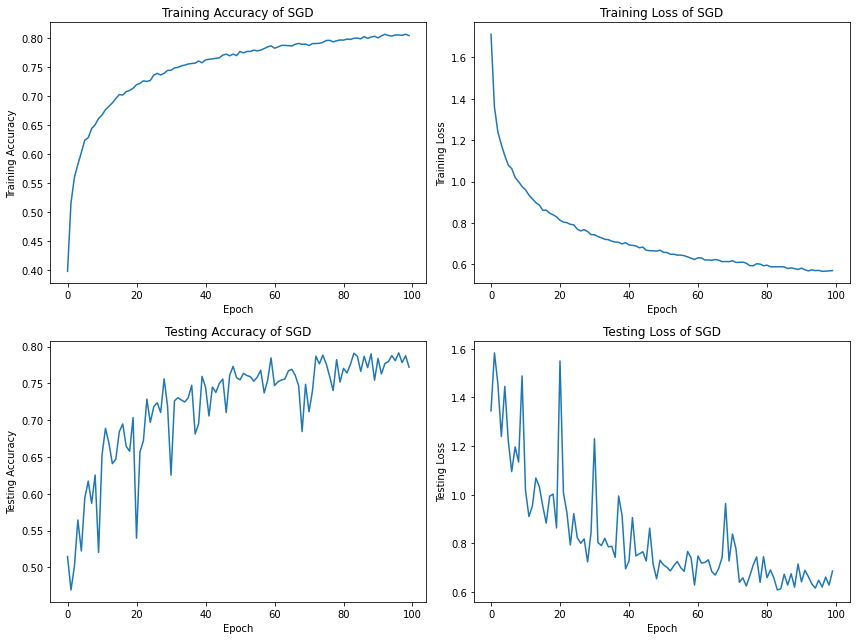

In [9]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of SGD')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of SGD')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of SGD')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of SGD')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()